# Binary Spam Classifier: NLP with LSTM in TensorFlow 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalAveragePooling1D, Embedding
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.4.1


In [2]:
# download spam dataset (originally from kaggle)
#!wget https://lazyprogrammer.me/course_files/spam.csv

# this data set is in a strange format so import and transform to make useful
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.columns = ['labels', 'data']
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1}) # create binary labels for spam
Y = df['b_labels'].values # set target vector

In [3]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [5]:
# split for train and test
X_train, X_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33)

## Text preprocessing

In [6]:
# convert sentences to sequences of ints
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('found %s unique tokens' %V)

found 7209 unique tokens


In [8]:
# pad sequences to get N x T matrix with constant T
X_train = pad_sequences(sequences_train)
print('shape of X_train tensor:', X_train.shape)

# set sequence length T
T = X_train.shape[1]

shape of X_train tensor: (3733, 189)


In [9]:
# pad test set in with same T used in train set
X_test = pad_sequences(sequences_test, maxlen=T)
print('shape of X_test tensor:', X_test.shape)

shape of X_test tensor: (1839, 189)


## Build and train model

In [10]:
# build LSTM model

# choose and set embedding dimensionality
# this is the size of the vector that will 
# ve used to represent words
D = 20

# set hidden state dimensionality
M = 15

# Note: we actually want to set the embedding dimensionsality
# to (V+1) x D because the first index starts from 1 (not 0)
# since 0 is used for padding and does not map to a word
i = Input(shape=(T,))
x = Embedding(V+1, D) (i)
x = LSTM(M, return_sequences=True) (x)
x = GlobalAveragePooling1D() (x)
x = Dense(1, activation='sigmoid') (x)

model = Model(i,x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train model
r = model.fit(X_train,
              Y_train,
              epochs=10,
              validation_data=(X_test, Y_test))

Epoch 1/10
117/117 [==============================] - 9s 23ms/step - loss: 0.5395 - accuracy: 0.8691 - val_loss: 0.3780 - val_accuracy: 0.8668
Epoch 2/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3697 - accuracy: 0.8692 - val_loss: 0.3580 - val_accuracy: 0.8668
Epoch 3/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3486 - accuracy: 0.8676 - val_loss: 0.3276 - val_accuracy: 0.8668
Epoch 4/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3182 - accuracy: 0.8640 - val_loss: 0.3041 - val_accuracy: 0.8668
Epoch 5/10
117/117 [==============================] - 2s 16ms/step - loss: 0.2708 - accuracy: 0.8757 - val_loss: 0.2774 - val_accuracy: 0.8668
Epoch 6/10
117/117 [==============================] - 2s 16ms/step - loss: 0.2548 - accuracy: 0.8722 - val_loss: 0.2616 - val_accuracy: 0.8679
Epoch 7/10
117/117 [==============================] - 2s 16ms/step - loss: 0.2586 - accuracy: 0.8486 - val_loss: 0.2464 - val_accuracy: 0.8668

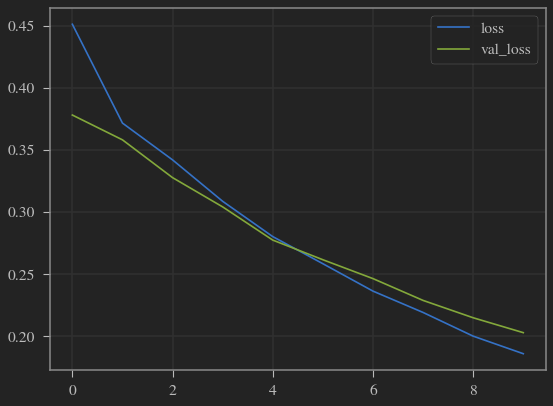

In [11]:
# plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

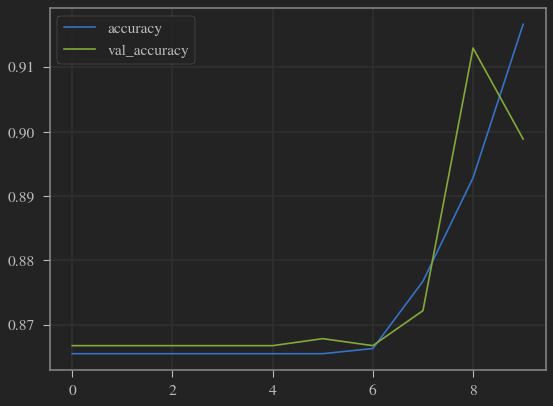

In [12]:
# plot accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();

## Test examples

In [13]:
predictions = np.round(model.predict(X_test)[:,0])
predictions

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions)

array([[1594,    0],
       [ 186,   59]], dtype=int64)